In [1]:
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
import time

This tutorial explores _optimization for machine learning_.

We will implement a function and then use gradient-based optimization to find it's minimum value. 
For ease of visualization we will consider scalar functions of 2-d vectors. 
In other words $f: \mathbb{R}^2 \rightarrow \mathbb{R}$

One example of such a function is the simple quadratic $$f(x) = \frac{1}{2} x^T x = \frac{1}{2}(x_0^2 + x_1^2)$$ where $x_i$ represents the $i$-th entry of the vector $x$.

Let's implement this in code and print $f(x)$ for a few random $x$

In [2]:
def f(x):
    return 0.5*np.dot(x.T, x)

for _ in range(5):  
    x = np.random.randn(2)  # random 2-d vector
    print('x={}, f(x)={:.3f}'.format(x, f(x)))

x=[-0.729  0.147], f(x)=0.277
x=[-1.644  0.519], f(x)=1.487
x=[ 0.443 -1.585], f(x)=1.354
x=[0.703 0.287], f(x)=0.288
x=[1.001 1.273], f(x)=1.312


This simple function has minimum value $f(x^*)=0$ given by $x^* = [0, 0]^T$. 

Let's look at the more general quadratic 
$$f(x) = \frac{1}{2}x^T A x$$
where $A \in \mathbb{R}^{2 \times 2}$ is a positive semi-definite matrix.

Notice that we get the previous function when we set $A$ to the identity matrix $I$.

We can think of this function as a quadratic bowl whose curvature is specified by the value of $A$.
This is evident in the isocontour plots of $f(x)$ for various $A$.
Let's take a look.


In [3]:
# helper function yielding a random positive semi-definite matrix
def random_psd_matrix(seed=None):
    """return random positive semi-definite matrix with norm one"""
    np.random.seed(seed)
    A = np.random.randn(2,2)
    A = np.dot(A.T,A)
    A = np.dot(A.T,A)
    A = A / np.linalg.norm(A)
    return A

# define forward function
def f(x, a):
    """f(x) = x^T A x"""
    y = 0.5*np.dot(x.T, np.dot(a, x))
    return y

# helper function for isocontour plotting
def plot_isocontours(one_d_grid, g):
    """
    first makes a 2d grid from the 1d grid
    then plots isocontours using the function g
    """
    X,Y = np.meshgrid(one_d_grid, one_d_grid)  # build 2d grid
    Z = np.zeros_like(X)
    # numpy bonus exercise: can you think of a way to vectorize the following for-loop?
    for i in range(len(X)):
        for j in range(len(X.T)):
            Z[i, j] = g(np.array((X[i, j], Y[i, j])))  # compute function values
    fig, ax = plt.subplots()
    ax.contour(X, Y, Z, 100)
    return fig, ax 

A=[[1. 1.]
 [1. 1.]]


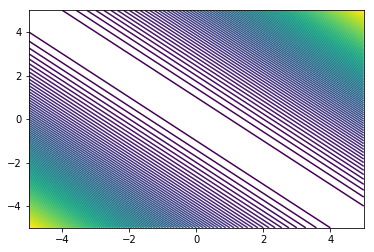

A=[[ 0.981 -0.136]
 [-0.136  0.019]]


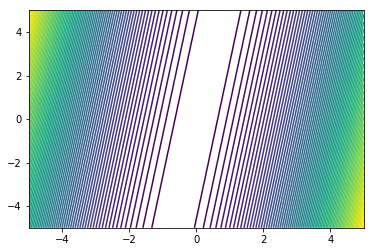

A=[[0.362 0.481]
 [0.481 0.638]]


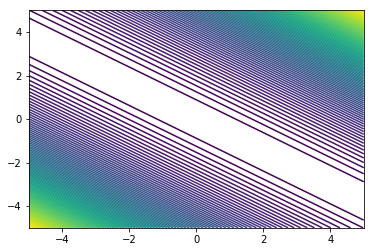

In [4]:
for A in [np.ones((2, 2)), random_psd_matrix(), random_psd_matrix()]:  # try a few values of A
    print('A={}'.format(A))
    fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))
    plt.show()
    time.sleep(1.0)

Now let's learn how to find the minimal value of $f(x)$. 
We need to solve the following optimization problem:
$$x^* = \underset{x}{\arg \min} \quad \frac{1}{2}x^T A x = \underset{x}{\arg \min} \quad f(x)$$


Modern machine learning optimization tools rely on gradients. 
Consider gradient descent, which initializes $x_0$ at random then follows the update rule 
$$ x_{t+1} \leftarrow x_t - \eta \nabla_x f(x_t)$$
where $\eta$ represents the learning rate.

So we need to compute $\nabla_x f(x)$. For simple functions like ours, we can compute this analytically:
$$\nabla_x f(x) = \nabla_x \left( \frac{1}{2}x^T A x \right) = A x$$

In other words, to compute the gradient of $f(x)$ at a particular $x=x'$, we matrix multiply $A$ with $x'$

But deriving the analytic gradients by hand becomes painful as $f$ gets more complicated. Instead we can use automatic differentation packages like [`autograd`](https://github.com/HIPS/autograd) to do this hard work for us. All we need to do is specify the forward function.

Let's take a look at the two approaches:

In [5]:
# define df/dx via automatic differentiation
df_dx = autograd.grad(f, 0)
# ^ the second argument of grad specifies which argument we're differentiating with respect to

# define df/dx analytically 
def analytic_gradient(x, A):
    return np.dot(A, x)

for A in [np.zeros((2, 2)), np.eye(2), random_psd_matrix()]:  # try a few values of A
    x = np.random.randn(2)  # generate x randomly
    print('')
    print('x={}\nA={}\nf(x,A)={:.3f}\ndf/dx={}'.format(x, A, f(x,A), df_dx(x,A)))
    assert np.isclose(np.sum((df_dx(x, A) - analytic_gradient(x, A)))**2, 0.), 'bad maths'  # unit test
    


x=[-1.425 -0.077]
A=[[0. 0.]
 [0. 0.]]
f(x,A)=0.000
df/dx=[0. 0.]

x=[-0.119  0.476]
A=[[1. 0.]
 [0. 1.]]
f(x,A)=0.120
df/dx=[-0.119  0.476]

x=[-2.304  1.704]
A=[[ 0.053 -0.004]
 [-0.004  0.999]]
f(x,A)=1.607
df/dx=[-0.129  1.712]


Now that we know how to compute $\nabla_x f(x)$ using `autograd`, let's implement gradient descent.

To make the implementation of GD crystal clear, let's break this update expression from above into two lines:
$$ \delta_{t+1} \leftarrow - \eta \nabla_x f(x_t)$$
$$ x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

final value f(x)=0.236 at x=[ 1.224 -1.689]


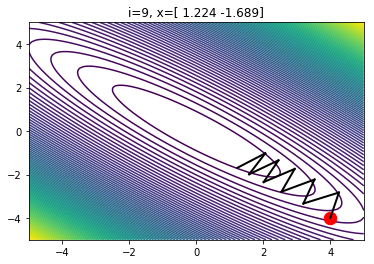

In [6]:
A = random_psd_matrix(0)  # argument specifies the random seed
fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

# hyperparameters
LEARNING_RATE = 2.0
INITIAL_VAL = np.array([4., -4.])  # initialize

x = np.copy(INITIAL_VAL)
ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values



from IPython import display

for i in range(10):
#    input("Press Enter to continue...")  # optional; Enter key triggers next update
#    time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

    x_old = np.copy(x)
    delta = -LEARNING_RATE*df_dx(x, A)  # compute gradient times learning rate
    x += delta  # update params
    
    # plot
    ax.plot([x_old[0], x[0]], [x_old[1], x[1]], linestyle='-', color='k',lw=2)  # plot a line connecting old and new param values
    fig.canvas.draw()
    ax.set_title('i={}, x={}'.format(i, x))
    display.display(fig)
    display.clear_output(wait=True)

print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))


Cool! Now let's try gradient descent _with momentum_. The hyperparameters are the learning rate $\eta$ and momentum value $\alpha \in [0, 1)$.

We randomly initialize $x_0$ like before. We initialize $\delta_0$ to the zero vector. Then proceed with updates as:
$$\delta_{t+1} \leftarrow -\eta \nabla_x f(x) + \alpha \delta_t$$
$$x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

final value f(x)=0.085 at x=[-1.467  1.109]


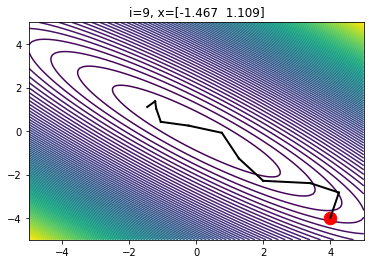

In [7]:
fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

# initialize
x = np.copy(INITIAL_VAL)
delta = np.zeros(2)
ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values

# hyperparameters
LEARNING_RATE = 2.0
ALPHA = 0.8

from IPython import display

for i in range(10):
#    input("Press Enter to continue...")  # optional; Enter key triggers next update
#    time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

    x_old = np.copy(x)
    g = df_dx(x, A)  # compute standard gradient
    delta = -LEARNING_RATE*g + ALPHA*delta  # update momentum term
    x += delta  # update params
    
    # plot
    ax.plot([x_old[0], x[0]], [x_old[1], x[1]],'-k',lw=2)  # plot a line connecting old and new param values
    fig.canvas.draw()
    ax.set_title('i={}, x={}'.format(i, x))
    display.display(fig)
    display.clear_output(wait=True)

print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))


Nice! Now we can try different loss surfaces in the interactive portion of the tutorial.